# Ant Colony Optimization (ACO) for Graph Coloring
This notebook demonstrates how to solve the graph coloring problem using the Ant Colony System (ACS) metaheuristic. It includes the implementation and example use cases on standard benchmark instances.

## Understanding Ant Colony Optimization

### Nature's Inspiration
Ant Colony Optimization (ACO) is a metaheuristic inspired by the foraging behavior of real ants in nature. Ants can find shortest paths between food sources and their colony by depositing and following pheromone trails. This collective behavior emerges without central control:

1. Ants initially explore randomly
2. Upon finding food, they return to the colony, laying pheromone trails
3. Shorter paths accumulate pheromone faster (ants complete trips more quickly)
4. Pheromones evaporate over time (preventing convergence to suboptimal solutions)
5. Other ants are more likely to follow stronger pheromone trails

This positive feedback mechanism gradually leads the colony to converge on the shortest path between the nest and food sources.

### ACO Algorithm Components

The ACO metaheuristic translates this natural phenomenon into an optimization algorithm with the following key components:

1. **Artificial Ants**: Each ant constructs a candidate solution incrementally
2. **Pheromone Trails**: Numerical values associated with solution components (edges, nodes)
3. **Heuristic Information**: Problem-specific knowledge to guide solution construction
4. **Pheromone Updating**: Rules for depositing and evaporating pheromones based on solution quality
5. **Solution Construction**: Probabilistic decision-making combining pheromones and heuristics

The Ant Colony System (ACS) variant used in this notebook enhances the basic ACO with:

- A state transition rule balancing exploration and exploitation via q₀ parameter
- Local pheromone updates during solution construction
- Global pheromone updates applied only to best solutions

![Ant Colony Optimization](https://upload.wikimedia.org/wikipedia/commons/a/af/Aco_branches.svg)

## Graph Coloring Problem Formulation

### Problem Statement

The Graph Coloring Problem (GCP) is one of the fundamental NP-hard problems in graph theory and combinatorial optimization. The objective is to assign colors to the vertices of a graph such that no adjacent vertices share the same color, while minimizing the number of colors used.

Formally, given an undirected graph G = (V, E) where:
- V is the set of vertices (nodes)
- E is the set of edges connecting pairs of vertices

The goal is to find a coloring function c: V → {1, 2, ..., k} such that:
- For every edge (u, v) ∈ E, c(u) ≠ c(v) (adjacent vertices have different colors)
- The value of k (number of colors used) is minimized

The minimum value of k for which a proper coloring exists is called the chromatic number χ(G) of the graph.

### Applications of Graph Coloring

Graph coloring has numerous practical applications:

- **Scheduling problems**: Assigning time slots to events that cannot overlap
- **Register allocation** in compilers: Assigning registers to variables
- **Frequency assignment** in wireless networks: Allocating channels to minimize interference
- **Map coloring**: Ensuring adjacent regions have distinct colors
- **Pattern matching** and **resource allocation**

## ACO Modelization for Graph Coloring

Adapting ACO to solve the graph coloring problem requires careful modeling. Our implementation follows these design choices:

### 1. Solution Construction Process

Instead of directly assigning colors, we use ACO to generate an ordering of vertices. This ordering is then processed using a greedy coloring approach:

- Ants construct a permutation (ordering) of vertices
- Vertices are colored sequentially according to this ordering
- Each vertex receives the smallest available color that doesn't conflict with its already-colored neighbors

This two-phase approach transforms the problem into finding the optimal vertex ordering that minimizes colors when processed greedily.

### 2. Pheromone Representation

Our pheromone model uses a matrix where:
- τ(i,j) represents the desirability of placing vertex j after vertex i in the ordering
- Higher pheromone values indicate stronger preference for this sequencing

### 3. Heuristic Information

The heuristic information η combines multiple factors:
- **Saturation degree**: Number of different colors assigned to neighbors
- **Vertex degree**: Number of connections (higher degree vertices are more constrained)

### 4. Decision Rule

When selecting the next vertex in the ordering, an ant uses:
- An exploitation strategy (with probability q₀): Choose the vertex with highest combined pheromone and heuristic value
- An exploration strategy (with probability 1-q₀): Probabilistically select based on proportional weights

### 5. Pheromone Updates

- **Local updates** during solution construction discourage other ants from making identical choices
- **Global updates** after all ants complete their solutions reinforce components of the best solutions
- **Pheromone evaporation** prevents premature convergence to suboptimal solutions

## Algorithm Parameters and Their Impact

Our ACO implementation uses several parameters that control the algorithm's behavior:

| Parameter | Description | Effect |
|-----------|-------------|--------|
| `alpha` | Controls influence of pheromone trails | Higher values favor exploitation of known good paths |
| `beta` | Controls influence of heuristic information | Higher values favor choices with better immediate gains |
| `rho` | Pheromone evaporation rate | Higher values cause faster forgetting of past solutions |
| `q0` | Probability of choosing best option | Higher values increase exploitation vs exploration |
| `num_ants` | Number of artificial ants | More ants provide more exploration but increase computation |
| `initial_pheromone` | Starting pheromone value | Sets initial exploration level |
| `max_iterations` | Number of algorithm iterations | More iterations allow further optimization but take longer |

The performance of ACO for graph coloring depends on finding the right balance between exploration (discovering new promising regions) and exploitation (refining solutions in known good regions).

## 1. Import Required Libraries

In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

## 2. Helper: Read DIMACS Graph File

In [2]:
def read_dimacs_file(filepath):
    G = nx.Graph()
    nodes_added = set()
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('c'):
                continue
            if line.startswith('p'):
                parts = line.split()
                num_nodes = int(parts[2])
                for i in range(1, num_nodes + 1):
                    G.add_node(i)
                    nodes_added.add(i)
            elif line.startswith('e'):
                parts = line.split()
                node1 = int(parts[1])
                node2 = int(parts[2])
                if node1 not in nodes_added:
                    G.add_node(node1)
                    nodes_added.add(node1)
                if node2 not in nodes_added:
                    G.add_node(node2)
                    nodes_added.add(node2)
                G.add_edge(node1, node2)
    return G

## 3. Ant Colony System for Graph Coloring: Implementation

In [3]:
class AntColonySystemGraphColoring:
    def __init__(self, graph, num_ants=10, alpha=1.0, beta=2.0, rho=0.1, q0=0.9, initial_pheromone=0.1, max_iterations=100):
        self.graph = graph
        self.nodes = list(graph.nodes())
        self.num_nodes = len(self.nodes)
        self.num_ants = num_ants
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q0 = q0
        self.initial_pheromone = initial_pheromone
        self.max_iterations = max_iterations
        self.pheromone = {}
        for u in self.nodes:
            for v in self.nodes:
                if u != v:
                    self.pheromone[(u, v)] = self.initial_pheromone
        self.node_to_index = {node: idx for idx, node in enumerate(self.nodes)}
        self.node_degrees = {node: graph.degree(node) for node in self.nodes}
        self.candidate_lists = {node: self.build_extended_candidate_list(node) for node in self.nodes}
        self.best_coloring = None
        self.best_ordering = None
        self.best_num_colors = float('inf')
        self.global_best_coloring = None
        self.global_best_ordering = None
        self.global_best_num_colors = float('inf')

    def build_extended_candidate_list(self, node):
        candidates = set(self.graph.neighbors(node))
        for neighbor in self.graph.neighbors(node):
            for second_neighbor in self.graph.neighbors(neighbor):
                if second_neighbor != node and second_neighbor not in candidates:
                    candidates.add(second_neighbor)
        return list(candidates)

    def get_pheromone(self, node1, node2):
        return self.pheromone.get((node1, node2), self.initial_pheromone)

    def update_pheromone(self, node1, node2, value):
        self.pheromone[(node1, node2)] = value

    def get_valid_colors(self, node, colored_nodes, coloring):
        neighbor_colors = set()
        for neighbor in self.graph.neighbors(node):
            if neighbor in colored_nodes:
                neighbor_colors.add(coloring[neighbor])
        color = 0
        while color in neighbor_colors:
            color += 1
        return color

    def color_graph(self, ordering):
        coloring = {}
        colored_nodes = set()
        for node in ordering:
            color = self.get_valid_colors(node, colored_nodes, coloring)
            coloring[node] = color
            colored_nodes.add(node)
        num_colors = max(coloring.values()) + 1 if coloring else 0
        return coloring, num_colors

    def calculate_saturation_degree(self, node, colored_nodes, coloring):
        colors_used = set()
        for neighbor in self.graph.neighbors(node):
            if neighbor in colored_nodes:
                colors_used.add(coloring[neighbor])
        return len(colors_used)

    def calculate_node_weights(self, current_node, uncolored_nodes, colored_nodes, coloring):
        weights = {}
        candidates = [n for n in self.candidate_lists[current_node] if n in uncolored_nodes]
        if not candidates:
            candidates = uncolored_nodes
        for candidate in candidates:
            sat_degree = self.calculate_saturation_degree(candidate, colored_nodes, coloring)
            heuristic_value = 1.0 + sat_degree
            heuristic_value *= (1 + 0.1 * self.node_degrees[candidate])
            pheromone_value = self.get_pheromone(current_node, candidate)
            weights[candidate] = (pheromone_value ** self.alpha) * (heuristic_value ** self.beta)
        return weights

    def select_next_node(self, current_node, uncolored_nodes, colored_nodes, coloring):
        if not uncolored_nodes:
            return None
        weights = self.calculate_node_weights(current_node, uncolored_nodes, colored_nodes, coloring)
        q = random.random()
        if q <= self.q0:
            if weights:
                return max(weights.items(), key=lambda x: x[1])[0]
            else:
                return random.choice(uncolored_nodes)
        else:
            total_weight = sum(weights.values())
            if total_weight == 0:
                return random.choice(uncolored_nodes)
            probabilities = [weights[node] / total_weight for node in weights.keys()]
            selected_node = random.choices(list(weights.keys()), weights=probabilities, k=1)[0]
            return selected_node

    def local_pheromone_update(self, node1, node2):
        old_value = self.get_pheromone(node1, node2)
        new_value = (1 - self.rho) * old_value + self.rho * self.initial_pheromone
        self.update_pheromone(node1, node2, new_value)

    def global_pheromone_update(self, best_coloring, best_ordering, best_num_colors):
        quality = 1.0 / best_num_colors
        for i in range(len(best_ordering) - 1):
            node1 = best_ordering[i]
            node2 = best_ordering[i + 1]
            old_value = self.get_pheromone(node1, node2)
            new_value = (1 - self.rho) * old_value + self.rho * quality
            self.update_pheromone(node1, node2, new_value)
        for i, node1 in enumerate(self.nodes):
            for j, node2 in enumerate(self.nodes):
                if i < j and best_coloring.get(node1) == best_coloring.get(node2):
                    if not self.graph.has_edge(node1, node2):
                        common_neighbors = set(self.graph.neighbors(node1)) & set(self.graph.neighbors(node2))
                        if common_neighbors:
                            old_value = self.get_pheromone(node1, node2)
                            new_value = (1 - self.rho) * old_value + self.rho * quality * 0.5
                            self.update_pheromone(node1, node2, new_value)

    def construct_solution_for_ant(self, ant_id):
        probabilities = [self.node_degrees[node] for node in self.nodes]
        total = sum(probabilities)
        if total > 0:
            probabilities = [p / total for p in probabilities]
            current_node = random.choices(self.nodes, weights=probabilities, k=1)[0]
        else:
            current_node = random.choice(self.nodes)
        uncolored_nodes = list(self.nodes)
        uncolored_nodes.remove(current_node)
        colored_nodes = {current_node}
        partial_coloring = {current_node: 0}
        node_ordering = [current_node]
        while uncolored_nodes:
            next_node = self.select_next_node(current_node, uncolored_nodes, colored_nodes, partial_coloring)
            if next_node:
                self.local_pheromone_update(current_node, next_node)
                color = self.get_valid_colors(next_node, colored_nodes, partial_coloring)
                partial_coloring[next_node] = color
                node_ordering.append(next_node)
                uncolored_nodes.remove(next_node)
                colored_nodes.add(next_node)
                current_node = next_node
        coloring, num_colors = self.color_graph(node_ordering)
        return coloring, num_colors, node_ordering

    def run(self, verbose=True):
        start_time = time.time()
        for iteration in range(self.max_iterations):
            if verbose and (iteration % 5 == 0 or iteration == self.max_iterations - 1):
                print(f"Iteration {iteration + 1}/{self.max_iterations}")
            self.best_coloring = None
            self.best_ordering = None
            self.best_num_colors = float('inf')
            for ant in range(self.num_ants):
                coloring, num_colors, node_ordering = self.construct_solution_for_ant(ant)
                if num_colors < self.best_num_colors:
                    self.best_coloring = coloring.copy()
                    self.best_ordering = node_ordering.copy()
                    self.best_num_colors = num_colors
                if num_colors < self.global_best_num_colors:
                    self.global_best_coloring = coloring.copy()
                    self.global_best_ordering = node_ordering.copy()
                    self.global_best_num_colors = num_colors
                    if verbose:
                        print(f"  Found better solution with {self.global_best_num_colors} colors")
            self.global_pheromone_update(self.best_coloring, self.best_ordering, self.best_num_colors)
            if verbose and iteration % 5 == 0:
                elapsed = time.time() - start_time
                print(f"  Time elapsed: {elapsed:.2f}s, Best solution: {self.global_best_num_colors} colors")
        elapsed = time.time() - start_time
        if verbose:
            print(f"\nFinal result: {self.global_best_num_colors} colors in {elapsed:.2f} seconds")
        return self.global_best_coloring, self.global_best_num_colors

    def is_valid_coloring(self):
        if self.global_best_coloring is None:
            return False, ["No solution found yet"]
        conflicts = []
        for u, v in self.graph.edges():
            if self.global_best_coloring[u] == self.global_best_coloring[v]:
                conflicts.append((u, v))
        return len(conflicts) == 0, conflicts

## 4. Example Use Case: Run ACO on a DIMACS Instance

In [4]:
# Select a graph instance (change the path to try other instances)
graph_path = '../data/dsjc250.5.col'
G = read_dimacs_file(graph_path)
print(f'Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.')

# Set ACO parameters
aco = AntColonySystemGraphColoring(
    G,
    num_ants=10,
    alpha=1.0,
    beta=2.0,
    rho=0.1,
    q0=0.9,
    initial_pheromone=0.1,
    max_iterations=50
)

# Run the algorithm
best_coloring, best_num_colors = aco.run(verbose=True)
print(f'Best coloring uses {best_num_colors} colors.')
valid, conflicts = aco.is_valid_coloring()
print('Valid coloring:', valid)

Graph loaded with 250 nodes and 15668 edges.
Iteration 1/50
  Found better solution with 40 colors
  Found better solution with 39 colors
  Found better solution with 38 colors
  Time elapsed: 2.59s, Best solution: 38 colors
  Found better solution with 37 colors
Iteration 6/50
  Time elapsed: 15.55s, Best solution: 37 colors
Iteration 11/50
  Time elapsed: 28.41s, Best solution: 37 colors
Iteration 16/50
  Time elapsed: 41.24s, Best solution: 37 colors
  Found better solution with 36 colors
Iteration 21/50
  Time elapsed: 54.02s, Best solution: 36 colors
Iteration 26/50
  Time elapsed: 66.78s, Best solution: 36 colors
Iteration 31/50
  Time elapsed: 79.67s, Best solution: 36 colors
Iteration 36/50
  Time elapsed: 92.53s, Best solution: 36 colors
Iteration 41/50
  Time elapsed: 105.35s, Best solution: 36 colors
Iteration 46/50
  Time elapsed: 118.17s, Best solution: 36 colors
Iteration 50/50

Final result: 36 colors in 128.52 seconds
Best coloring uses 36 colors.
Valid coloring: True


## 5. Visualize the Best Coloring

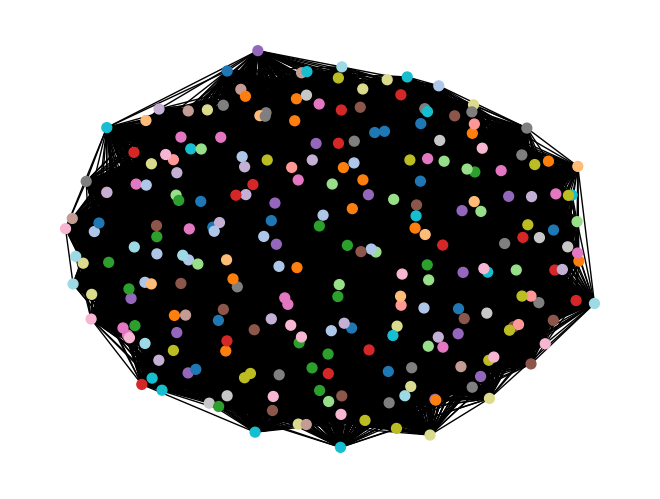

In [5]:
def plot_coloring(G, coloring):
    colors = [coloring[node] for node in G.nodes()]
    nx.draw_spring(G, node_color=colors, with_labels=False, node_size=50, cmap=plt.cm.tab20)
    plt.show()

plot_coloring(G, best_coloring)